# <ins>__Natural Language Processing for Movie Reviews__<ins>


__Purpose:__ This Python script aims to perform sentiment analysis on a dataset consisting of 25,000 movie reviews. The goal is to classify each review as either positive or negative based on its textual content.
The ultimate objective of this script is to build and evaluate models capable of accurately predicting the sentiment in human-created text.



__Data used:__ 
* _labeledTrainData_ - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review.  
* _testData_ - The test set. The tab-delimited file has a header row followed by 25,000 rows containing an id and text for each review. Your task is to predict the sentiment for each one. 
* _unlabeledTrainData_ - An extra training set with no labels. The tab-delimited file has a header row followed by 50,000 rows containing an id and text for each review. 



__Steps:__ 
> 1. Data Preprocessing:
>> * The movie review dataset is loaded and preprocessed to remove HTML tags, punctuation, and stopwords.
>> * The cleaned text data is tokenized into words and sentences.
> 2. Word Embedding with Word2Vec:
>> * The Word2Vec algorithm is employed to learn distributed representations of words from the movie review corpus.
>> * Word embeddings capture semantic relationships between words, allowing for better understanding of their meanings in context.
> 3. Feature Extraction:
>> * The average feature vectors for each review are computed by averaging the Word2Vec word embeddings of its constituent words.
>> * These average feature vectors serve as numerical representations of the review texts and are used as input for classification.
> 4. Classification:
>> * Two classification approaches are implemented:
>>> * Random Forest Classifier: A machine learning model is trained on the training data to classify reviews into positive or negative categories.
>>> * KMeans Clustering: Unsupervised clustering is performed to group similar reviews together based on their feature representations.

## <ins>Load the needed libraries<ins>

In [1]:
# Install necessary libraries
!pip install -q BeautifulSoup4 scikit-learn nltk gensim

# runtime ~ 10s

In [2]:
# Import necessary libraries
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for data manipulation and analysis
import os  # Operating system module for interacting with the file system
import re  # Regular expression module for pattern matching
import logging  # Logging module for logging messages
import time  # Time module for time-related operations
import warnings  # Warnings module for handling warnings
import matplotlib.pyplot as plt # For plotting graphs
from bs4 import BeautifulSoup  # BeautifulSoup for parsing HTML or XML documents

import gensim  # Gensim library for topic modeling, document similarity, etc.
from gensim.models import Word2Vec  # Word2Vec model for word embeddings

import nltk  # Natural Language Toolkit for natural language processing tasks
from nltk.corpus import stopwords  # NLTK's stopwords corpus for common stopwords
from nltk import word_tokenize, sent_tokenize  # NLTK's tokenization functions for words and sentences

from sklearn.feature_extraction.text import CountVectorizer  # Scikit-learn's CountVectorizer for converting text data to numerical vectors
from sklearn.ensemble import RandomForestClassifier  # Scikit-learn's RandomForestClassifier for classification tasks
from sklearn.cluster import KMeans  # Scikit-learn's KMeans for clustering tasks
from sklearn.metrics import roc_curve, auc # For computing ROC curve and AUC

# runtime ~ 5s

In [3]:
# The 'stopwords' dataset is downloaded, which contains common words that are usually filtered out during text preprocessing.
nltk.download('stopwords')

# The 'punkt' tokenizer dataset is downloaded, which is used for tokenization, i.e., splitting text into individual words or sentences.
nltk.download('punkt')

# The punkt tokenizer for English language is loaded using nltk.data.load(), which will be used for sentence tokenization.
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# runtime ~ 5s

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\craig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# <ins>Set directory and load tsv data into Pandas Dataframe<ins>

In [4]:
# Set the working directory path where the data files are located is specified.
Directory = r'D:\TechWork\NonConfidentialProjects\NLPForMovieReviews'

# Dataframes TrainDF, TestDF, and UnlabeledTrainDF are created to hold the data from the respective files.
# The labeled training data, test data, and unlabeled training data are read using pd.read_csv() function, with appropriate parameters:
TrainDF = pd.read_csv(os.path.join(Directory, "labeledTrainData.tsv"), header=0, delimiter="\t", quoting=3)
TestDF = pd.read_csv(os.path.join(Directory, "testData.tsv"), header=0, delimiter="\t", quoting=3)
UnlabeledTrainDF = pd.read_csv(os.path.join(Directory, "unlabeledTrainData.tsv"), header=0, delimiter="\t", quoting=3)

# runtime ~ 1s

In [5]:
# Print the first review from the TrainDF dataframe, to see what a review may look like
print(TrainDF["review"][0])

# runtime ~ 1s

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

# <ins>Data Preprocessing<ins>

In [6]:
# The BeautifulSoup object is initialized with the raw HTML content of the first movie review from TrainDF["review"].
example1 = BeautifulSoup(TrainDF["review"][0], "html.parser")  

# Print the raw review and then the output of get_text(), for comparison
print("Raw Review:")
print(TrainDF["review"][0])

print("\nProcessed Review (after removing HTML tags):")
print(example1.get_text())

# runtime ~ 1s

Raw Review:
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it

In [7]:
# Use regular expressions to find and replace non-alphabetic characters with a space
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for (non-alphabetic characters)
                      " ",                   # The pattern to replace non-alphabetic characters with (a space)
                      example1.get_text() )  # The text to search (processed review)

# Print the result
print(letters_only)

# runtime ~ 1s

 With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

In [8]:
# Convert the processed review text to lowercase, with only alphabetic characters and spaces.
lower_case = letters_only.lower()

# Split the lowercase text into individual words. The resulting list 'words' contains all the words from the review text, with each word as an element of the list.
words = lower_case.split()

# runtime ~ 1s

In [9]:
# Retrieves a list of stopwords specific to the English language from NLTK's stopwords corpus.
print(stopwords.words("english"))

# runtime ~ 1s

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
# Remove stopwords from the list of words
words = [w for w in words if w not in stopwords.words("english")]

# Print the updated list of words
print(words)

# runtime ~ 1s

['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary', 'watched', 'wiz', 'watched', 'moonwalker', 'maybe', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'really', 'cool', 'eighties', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'going', 'see', 'cinema', 'originally', 'released', 'subtle', 'messages', 'mj', 'feeling', 'towards', 'press', 'also', 'obvious', 'message', 'drugs', 'bad', 'kay', 'visually', 'impressive', 'course', 'michael', 'jackson', 'unless', 'remotely', 'like', 'mj', 'anyway', 'going', 'hate', 'find', 'boring', 'may', 'call', 'mj', 'egotist', 'consenting', 'making', 'movie', 'mj', 'fans', 'would', 'say', 'made', 'fans', 'true', 'really', 'nice', 'actual', 'feature', 'film', 'bit', 'finally', 'starts', 'minutes', 'excluding', 'smooth', 'criminal', 'sequence', 'joe', 'pesci', 'convincing', 'psychopathic', 'powerful', 'drug', 'lord', 

In [11]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)

    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 

    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 

    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             

    # 4. In Python, searching a set is much faster than searching
    #    a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  

    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   

    # 6. Join the words back into one string separated by space, 
    #    and return the result.
    return " ".join(meaningful_words)

# runtime ~ 1s

In [12]:
# Call the review_to_words function to preprocess the first review in TrainDF dataframe, 
# removing HTML tags, non-letter characters, converting to lowercase, and removing stopwords.
clean_review = review_to_words(TrainDF["review"][0])

# Print the preprocessed review
print(clean_review)

# runtime ~ 1s

stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate working

In [13]:
print("Cleaning and parsing the training set movie reviews...\n")

clean_train_reviews = []

num_reviews = 25000
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print("Review %d of %d\n" % ( i+1, num_reviews ))                                                                    
    clean_train_reviews.append( review_to_words( TrainDF["review"][i] ))

# runtime ~ 10s

Cleaning and parsing the training set movie reviews...



C:\Users\craig\AppData\Local\Temp\ipykernel_7144\442277322.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review).get_text()


Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



## <ins>Create bag of words<ins>

In [14]:
print("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object
# CountVectorizer converts a collection of text documents into a matrix of token counts

vectorizer = CountVectorizer(analyzer="word",       # Tokenizes input text into words
                             tokenizer=None,       # Use the default tokenizer
                             preprocessor=None,   # Use the default preprocessor
                             stop_words=None,     # Do not remove stop words (already done)
                             max_features=5000)   # Limit the vocabulary size to 5000 words

# fit_transform() does two functions:
# - Fits the model and learns the vocabulary
# - Transforms our training data into feature vectors
# The input to fit_transform should be a list of strings
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Convert the result to a NumPy array for easier manipulation
train_data_features = train_data_features.toarray()

# runtime ~ 2s

Creating the bag of words...



In [15]:
# Print the shape of the feature vectors obtained after applying the bag-of-words transformation
print(train_data_features.shape)

# runtime ~ 1s

(25000, 5000)


In [16]:
# Take a look at the words in the vocabulary
vocab = vectorizer.vocabulary_ # returns a dictionary where keys are words and values are the indices assigned to those words.
first_key = next(iter(vocab))
print(first_key)

# runtime ~ 1s

stuff


In [48]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# Print only the first three elements
for i, (tag, count) in enumerate(zip(vocab, dist)):
    if i < 3:
        print(count, tag)
    else:
        break

# runtime ~ 1s

187 stuff
125 going
108 moment


## <ins>Train and use the Random Forest<ins>

In [18]:
print("Training the random forest...")

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators=100)

# Fit the Random Forest classifier to the training set
# using the bag of words as features and the sentiment labels as the response variable
forest.fit(train_data_features, TrainDF["sentiment"])

# runtime ~ 30s

Training the random forest...


RandomForestClassifier()

In [19]:
# Make predictions on the training data using the trained Random Forest classifier
predictions = forest.predict(train_data_features)

# Print the predicted sentiment labels
print(predictions)

# Calculate the number of predictions made
num_predictions = len(predictions)
print("Number of predictions:", num_predictions)

# runtime ~ 2s

[1 1 0 ... 0 0 1]
Number of predictions: 25000


In [20]:
# Print the sentiment labels from the training data
print(TrainDF['sentiment'])

# runtime ~ 1s

0        1
1        1
2        0
3        0
4        1
        ..
24995    0
24996    0
24997    0
24998    0
24999    1
Name: sentiment, Length: 25000, dtype: int64


In [21]:
# Verify that there are 25,000 rows and 2 columns
print(TestDF.shape)

# Create an empty list and append the clean reviews one by one
num_reviews = len(TestDF["review"])
clean_test_reviews = [] 

print("Cleaning and parsing the test set movie reviews...\n")
for i in range(0,num_reviews):
    if( (i+1) % 1000 == 0 ):
        print("Review %d of %d\n" % (i+1, num_reviews))
    clean_review = review_to_words( TestDF["review"][i] )
    clean_test_reviews.append( clean_review )

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":TestDF["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "Bag_of_Words_model.csv", index=False, quoting=3 )

# runtime ~ 15s

(25000, 2)
Cleaning and parsing the test set movie reviews...



C:\Users\craig\AppData\Local\Temp\ipykernel_7144\442277322.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review).get_text()


Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



In [22]:
# Verify the number of reviews that were read (100,000 in total)
print("Read %d labeled train reviews, %d labeled test reviews, " \
 "and %d unlabeled reviews\n" % (TrainDF["review"].size,  
 TestDF["review"].size, UnlabeledTrainDF["review"].size ))

# runtime ~ 1s

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



## <ins>Oragnise sentences<ins>

In [23]:
def review_to_wordlist(review, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words. Returns a list of words.

    # 1. Remove HTML tags from the review text
    review_text = BeautifulSoup(review).get_text()

    # 2. Remove non-alphabetic characters from the review text
    review_text = re.sub("[^a-zA-Z]", " ", review_text)

    # 3. Convert words to lowercase and split them into individual words
    words = review_text.lower().split()

    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        # Get the set of English stopwords
        stops = set(stopwords.words("english"))
        # Filter out stopwords from the list of words
        words = [w for w in words if not w in stops]

    # 5. Return a list of words
    return words

# runtime ~ 1s

In [24]:
def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    
    # Initialize an empty list to store the parsed sentences
    sentences = []
    
    # 2. Loop over each sentence
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # 2.a. Call review_to_wordlist to convert the raw sentence into a list of words
            words_in_sentence = review_to_wordlist(raw_sentence, remove_stopwords)
            # 2.b. Append the list of words representing the sentence to the sentences list
            sentences.append(words_in_sentence)
            
    # Return the list of sentences (each sentence is a list of words, so this returns a list of lists)
    return sentences

# runtime ~ 1s

In [25]:
# Initialize an empty list to store the parsed sentences
sentences = []

# Print a message indicating the start of parsing sentences from the training set
print("Parsing sentences from training set...")

# Suppress MarkupResemblesLocatorWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Iterate through each review in the training set
    for review in TrainDF["review"]:
        # Call review_to_sentences function to parse the sentences from the review
        # and append the resulting list of sentences to the 'sentences' list
        sentences += review_to_sentences(review, tokenizer)

# Print a message indicating the start of parsing sentences from the unlabeled set
print("Parsing sentences from unlabeled set...")

# Suppress MarkupResemblesLocatorWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Iterate through each review in the unlabeled set
    for review in UnlabeledTrainDF["review"]:
        # Call review_to_sentences function to parse the sentences from the review
        # and append the resulting list of sentences to the 'sentences' list
        sentences += review_to_sentences(review, tokenizer)

# runtime ~ 1.5m

Parsing sentences from training set...
Parsing sentences from unlabeled set...


In [26]:
# The following line prints the length of the list 'sentences'
# assuming 'sentences' contains a list of strings representing sentences.
print(len(sentences))

# runtime ~ 1s

796172


In [27]:
# This line prints the first element of the list 'sentences'.
# It assumes that 'sentences' is a list containing strings representing sentences.
print(sentences[0])

# runtime ~ 1s

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']


## <ins>Train Word2Vec<ins>

In [28]:
# Configure logging to display nice output messages for Word2Vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set values for various parameters
num_features = 300    # Dimensionality of word vectors
min_word_count = 40   # Minimum frequency threshold for words to be included in the model
num_workers = 4       # Number of threads to run in parallel
context = 10          # Size of the window around the target word to consider
downsampling = 1e-3   # Downsample setting for frequent words

# Train the Word2Vec model using the provided sentences
print("Training model...")
model = Word2Vec(sentences, workers=num_workers, vector_size=num_features, 
                          min_count=min_word_count, window=context, sample=downsampling)

# If further training is not expected, calling init_sims makes the model more memory-efficient
model.init_sims(replace=True)

# Give the model a meaningful name and save it for later use
model_name = "300features_40minwords_10context"
model.save(model_name)

# runtime ~ 30s

2024-03-09 12:12:43,742 : INFO : collecting all words and their counts
2024-03-09 12:12:43,743 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-03-09 12:12:43,772 : INFO : PROGRESS: at sentence #10000, processed 225664 words, keeping 17775 word types
2024-03-09 12:12:43,804 : INFO : PROGRESS: at sentence #20000, processed 451738 words, keeping 24945 word types
2024-03-09 12:12:43,835 : INFO : PROGRESS: at sentence #30000, processed 670859 words, keeping 30027 word types
2024-03-09 12:12:43,867 : INFO : PROGRESS: at sentence #40000, processed 896841 words, keeping 34335 word types
2024-03-09 12:12:43,897 : INFO : PROGRESS: at sentence #50000, processed 1116082 words, keeping 37751 word types
2024-03-09 12:12:43,926 : INFO : PROGRESS: at sentence #60000, processed 1337544 words, keeping 40711 word types


Training model...


2024-03-09 12:12:43,957 : INFO : PROGRESS: at sentence #70000, processed 1560307 words, keeping 43311 word types
2024-03-09 12:12:43,987 : INFO : PROGRESS: at sentence #80000, processed 1779516 words, keeping 45707 word types
2024-03-09 12:12:44,018 : INFO : PROGRESS: at sentence #90000, processed 2003714 words, keeping 48121 word types
2024-03-09 12:12:44,048 : INFO : PROGRESS: at sentence #100000, processed 2225465 words, keeping 50190 word types
2024-03-09 12:12:44,078 : INFO : PROGRESS: at sentence #110000, processed 2444323 words, keeping 52058 word types
2024-03-09 12:12:44,108 : INFO : PROGRESS: at sentence #120000, processed 2666488 words, keeping 54098 word types
2024-03-09 12:12:44,138 : INFO : PROGRESS: at sentence #130000, processed 2892315 words, keeping 55837 word types
2024-03-09 12:12:44,168 : INFO : PROGRESS: at sentence #140000, processed 3104796 words, keeping 57324 word types
2024-03-09 12:12:44,199 : INFO : PROGRESS: at sentence #150000, processed 3330432 words, ke

In [29]:
# Tokenize the words to create a list of strings
words = "man woman child kitchen".split()

# Find the word that doesn't match using the Word2Vec model
odd_one_out = model.wv.doesnt_match(words)

# Print the odd word found
print("The odd one out is:", odd_one_out)

# Find the word that doesn't match in a different set of words
odd_one_out = model.wv.doesnt_match("france england germany berlin".split())

# runtime ~ 1s

The odd one out is: kitchen


In [30]:
# Find words most similar to the word "awful" using the Word2Vec model
similar_words = model.wv.most_similar("awful")

# Print the words most similar to "awful"
print("Words most similar to 'awful':", similar_words)

# runtime ~ 1s

Words most similar to 'awful': [('terrible', 0.7594439387321472), ('atrocious', 0.7511518597602844), ('horrible', 0.7340344190597534), ('dreadful', 0.7099202871322632), ('abysmal', 0.7090114951133728), ('horrendous', 0.6771639585494995), ('horrid', 0.6590012311935425), ('appalling', 0.6523253917694092), ('lousy', 0.6295070052146912), ('laughable', 0.6096417307853699)]


In [31]:
# Load the previously trained Word2Vec model
model = Word2Vec.load("300features_40minwords_10context")

# The loaded model can now be used for various word embedding tasks

# runtime ~ 1s

2024-03-09 12:13:14,896 : INFO : loading Word2Vec object from 300features_40minwords_10context
2024-03-09 12:13:14,918 : INFO : loading wv recursively from 300features_40minwords_10context.wv.* with mmap=None
2024-03-09 12:13:14,918 : INFO : setting ignored attribute cum_table to None
2024-03-09 12:13:14,989 : INFO : Word2Vec lifecycle event {'fname': '300features_40minwords_10context', 'datetime': '2024-03-09T12:13:14.989328', 'gensim': '4.3.2', 'python': '3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'loaded'}


In [32]:
# Check the type of the vectors in the Word2Vec model
vector_type = type(model.wv.vectors)

# Print the type of vectors
print("Type of vectors in the Word2Vec model:", vector_type)

# runtime ~ 1s

Type of vectors in the Word2Vec model: <class 'numpy.ndarray'>


In [33]:
# Retrieve the shape of the vectors in the Word2Vec model
vector_shape = model.wv.vectors.shape

# Print the shape of the vectors
print("Shape of vectors in the Word2Vec model:", vector_shape)

# runtime ~ 1s

Shape of vectors in the Word2Vec model: (16490, 300)


In [34]:
# Retrieve the word vector for the word "flower" from the Word2Vec model
flower_vector = model.wv["flower"]

# Print the word vector
print("Word vector for 'flower':", flower_vector)

# runtime ~ 1s

Word vector for 'flower': [-4.67801839e-02  2.46725641e-02 -3.88885811e-02  9.31036484e-04
 -3.27227712e-02 -3.89708541e-02  3.58093753e-02  1.58803850e-01
  9.00682062e-02 -1.42551050e-01 -9.26013105e-03  1.01140462e-01
  3.56683768e-02  6.61564171e-02 -3.15442085e-02  2.56157992e-03
 -5.54324538e-02 -1.54800370e-01 -1.96601432e-02 -3.44443358e-02
 -2.85147205e-02  1.00238603e-02  1.46239682e-03  3.58479582e-02
  9.72705036e-02 -1.22196339e-02 -2.12538429e-02 -2.02547084e-03
 -2.26993505e-02 -1.74752902e-02  7.60775059e-02 -2.54868306e-02
 -1.40028326e-02 -4.49804887e-02  3.33962590e-02  4.99773398e-02
  4.48636748e-02 -9.91472825e-02 -3.03907115e-02  4.50918674e-02
 -2.49587316e-02  4.38998118e-02  1.68409869e-02 -9.67370495e-02
 -6.94372579e-02  6.76694699e-03  5.53335324e-02  4.65603992e-02
 -4.41496894e-02  1.28011748e-01  7.76713938e-02  1.13603055e-01
 -9.23594609e-02  8.42753518e-03 -2.86817774e-02  8.05612877e-02
  7.24648684e-02  5.56198172e-02 -4.49642949e-02  1.50323641e-02

## <ins>Create feature vectors<ins>

In [35]:
def makeFeatureVec(words, model, num_features):
    #Function to average all of the word vectors in a given paragraph

    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype="float32")
    
    nwords = 0
    
    # Index2word is a set that contains the names of the words in 
    # the model's vocabulary. 
    index2word_set = set(model.wv.index_to_key)
    
    # Loop over each word in the paragraph and, if it is in the model's
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords += 1
            featureVec = np.add(featureVec, model.wv[word])
    
    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    
    return featureVec

# runtime ~ 1s

In [36]:
def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array
    
    # Initialize a counter
    counter = 0
    
    # Preallocate a 2D numpy array to store the feature vectors, for speed
    reviewFeatureVecs = np.zeros((len(reviews), num_features), dtype="float32")
    
    # Loop through the reviews
    for review in reviews:
        # Print a status message every 1000th review
        if counter % 1000 == 0:
            print("Review %d of %d" % (counter, len(reviews)))
        
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        
        # Increment the counter
        counter += 1
    
    return reviewFeatureVecs

# runtime ~ 1s

In [37]:
# Initialize an empty list to store the cleaned training reviews
clean_train_reviews = []

# Suppress MarkupResemblesLocatorWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Clean the training reviews by removing stopwords and tokenizing them
    for review in TrainDF["review"]:
        clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))

# Print a message indicating the start of creating average feature vectors for training data
print("Creating average feature vecs for training reviews...")

# Calculate average feature vectors for training data
trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features)

# Initialize an empty list to store the cleaned testing reviews
clean_test_reviews = []

# Suppress MarkupResemblesLocatorWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Clean the testing reviews by removing stopwords and tokenizing them
    for review in TestDF["review"]:
        clean_test_reviews.append(review_to_wordlist(review, remove_stopwords=True))

# Print a message indicating the start of creating average feature vectors for testing data
print("Creating average feature vecs for test reviews...")

# Calculate average feature vectors for testing data
testDataVecs = getAvgFeatureVecs(clean_test_reviews, model, num_features)

# runtime ~ 45s

Creating average feature vecs for training reviews...
Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Creating average feature vecs for test reviews...
Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 2500

## <ins>K Means with Random Forest<ins>

In [38]:
# Fit a random forest classifier to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators=100)

# Train the random forest classifier on the labeled training data
print("Fitting a random forest to labeled training data...")
forest.fit(trainDataVecs, TrainDF["sentiment"])

# Test the trained model and extract results 
result = forest.predict(testDataVecs)

# Write the test results to a CSV file
output = pd.DataFrame(data={"id": TestDF["id"], "sentiment": result})
output.to_csv("Word2Vec_AverageVectors.csv", index=False, quoting=3)

# runtime ~ 30s

Fitting a random forest to labeled training data...


In [39]:
# Start time
start = time.time()

# Set "k" (num_clusters) to be 1/5th of the vocabulary size or an average of 5 words per cluster
word_vectors = model.wv.vectors
num_clusters = int(word_vectors.shape[0] / 5)

# Initialize a KMeans object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters=num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering:", round(elapsed, 1), "seconds.")

# runtime ~ 15s

Time taken for K Means clustering: 18.5 seconds.


In [40]:
# Create a Word/Index dictionary, mapping each vocabulary word to a cluster number
word_centroid_map = dict(zip(model.wv.index_to_key, idx))

# runtime ~ 1s

In [41]:
# For the first 10 clusters
for cluster in range(10):
    # Print the cluster number
    print("\nCluster %d" % cluster)
    
    # Find all of the words for that cluster number, and print them out
    words = [word for word, centroid in word_centroid_map.items() if centroid == cluster]
    print(words)
    
# runtime ~ 1s


Cluster 0
['curve']

Cluster 1
['yeager']

Cluster 2
['attacks', 'havoc', 'accidents', 'wreak']

Cluster 3
['rampant', 'misogyny', 'titillation']

Cluster 4
['defends', 'abandoning', 'accuses', 'hypocrite', 'fancies']

Cluster 5
['penny', 'donna', 'angelo', 'lindsey']

Cluster 6
['patrick', 'matthew', 'ian', 'shaw', 'guinness', 'rea', 'atkins', 'fishburne', 'holm', 'mcshane', 'gackt', 'lew', 'schildkraut', 'spall']

Cluster 7
['clich', 'trite', 'cliche', 'stale', 'ridden', 'hackneyed', 'cliches', 'plotting', 'cliched', 'predictability']

Cluster 8
['sergio', 'nero', 'takashi', 'leone', 'milestone', 'akira', 'canon', 'corbucci', 'martino', 'wenders', 'varma', 'harlin']

Cluster 9
['allegedly', 'ambassador']


In [42]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    # Create a bag of centroids representation for a given list of words using a word centroid map.
        
    # The number of clusters is equal to the highest cluster index in the word/centroid map
    num_centroids = max(word_centroid_map.values()) + 1
    
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # Return the "bag of centroids"
    return bag_of_centroids

# runtime ~ 1s

In [43]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((TrainDF["review"].size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

# Repeat for test reviews 
test_centroids = np.zeros((TestDF["review"].size, num_clusters), dtype="float32")

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

# runtime ~ 15s

In [44]:
# Fit a random forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators=100)

# Fitting the forest may take a few minutes
print("Fitting a random forest to labeled training data...")
forest.fit(train_centroids, TrainDF["sentiment"])

# Predict sentiment labels for the test set
result = forest.predict(test_centroids)

# Write the test results to a CSV file
output = pd.DataFrame(data={"id": TestDF["id"], "sentiment": result})
output.to_csv("BagOfCentroids.csv", index=False, quoting=3)

# runtime ~ 15s

Fitting a random forest to labeled training data...


## <ins>Check Results<ins>

In [45]:
import pandas as pd

# Merge TrainDF and output DataFrames based on the 'id' column
merged_df = pd.merge(TrainDF, output, on='id')

# Check for correct predictions
merged_df['correct_prediction'] = merged_df['sentiment_x'] == merged_df['sentiment_y']

# Calculate the overall percentage of correct predictions
overall_percentage_correct = (merged_df['correct_prediction'].mean()) * 100

# Display the result
print(f"Overall percentage of correct predictions: {overall_percentage_correct:.2f}%")

# runtime ~ 1s

Overall percentage of correct predictions: 86.57%


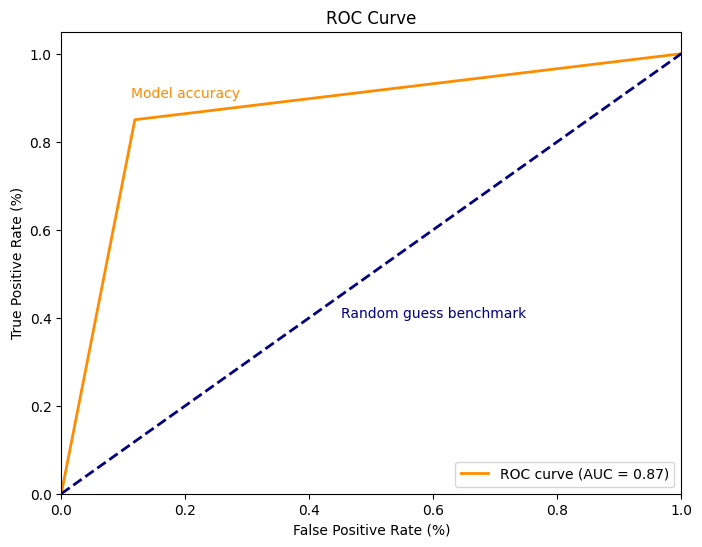

In [46]:
# Merge TrainDF and output DataFrames based on the 'id' column
merged_df = pd.merge(TrainDF, output, on='id')

# Assuming sentiment_x is the true labels and sentiment_y is the predicted probabilities
# Extracting true labels and predicted probabilities
true_labels = merged_df['sentiment_x']
predicted_probabilities = merged_df['sentiment_y']

# Calculate fpr, tpr, thresholds and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.text(0.6, 0.4, 'Random guess benchmark', fontsize=10, ha='center', color='navy')
plt.text(0.2, 0.9, 'Model accuracy', fontsize=10, ha='center', color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (%)')
plt.ylabel('True Positive Rate (%)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# runtime ~ 1s